In [1]:
import torch
import Biodata, CNmodel

In [2]:
import pandas as pd

In [5]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

pd.set_option('display.float_format', lambda x: '%.10f' % x) # Disable scientific notation and set decimal precision

########## Training on D. melanogaster ##########
Encoding sequences...
Node feature shape: (400, 256, 1)


d:\Job Projects\GNN-GeneEssentialityPrediction\venv_gcnn-sfm\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
d:\Job Projects\GNN-GeneEssentialityPrediction\venv_gcnn-sfm\lib\site-packages\torch_geometric\data\storage.py:452: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'y', 'x_dst', 'x_src', 'edge_index'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  warnings.warn(


trainset length:  280
testset length:  120
Epoch 1/200 | Loss: 0.6915 | Train Acc: 0.5544 | Val Acc: 0.4417
Epoch 2/200 | Loss: 0.6824 | Train Acc: 0.5625 | Val Acc: 0.4417
Epoch 3/200 | Loss: 0.6886 | Train Acc: 0.5231 | Val Acc: 0.4833
Epoch 4/200 | Loss: 0.6846 | Train Acc: 0.5359 | Val Acc: 0.4833
Epoch 5/200 | Loss: 0.6764 | Train Acc: 0.6053 | Val Acc: 0.4833
Epoch 6/200 | Loss: 0.6763 | Train Acc: 0.5567 | Val Acc: 0.4667
Epoch 7/200 | Loss: 0.6683 | Train Acc: 0.6053 | Val Acc: 0.4750
Epoch 8/200 | Loss: 0.6639 | Train Acc: 0.6389 | Val Acc: 0.4750
Epoch 9/200 | Loss: 0.6715 | Train Acc: 0.5752 | Val Acc: 0.5750
Epoch 10/200 | Loss: 0.6502 | Train Acc: 0.6736 | Val Acc: 0.5167
Epoch 11/200 | Loss: 0.6593 | Train Acc: 0.6169 | Val Acc: 0.5833
Epoch 12/200 | Loss: 0.6502 | Train Acc: 0.6053 | Val Acc: 0.4667
Epoch 13/200 | Loss: 0.6492 | Train Acc: 0.6435 | Val Acc: 0.5833
Epoch 14/200 | Loss: 0.6564 | Train Acc: 0.5984 | Val Acc: 0.4833
Epoch 15/200 | Loss: 0.6425 | Train Acc: 0

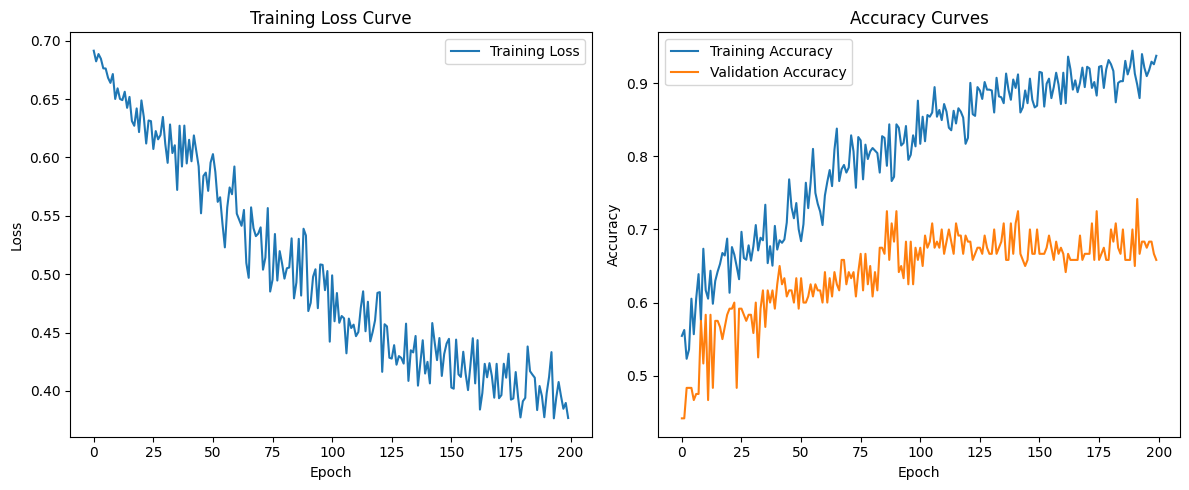

########## Testing on C. elegans ##########
Encoding sequences...
Node feature shape: (400, 256, 1)


d:\Job Projects\GNN-GeneEssentialityPrediction\src\CNmodel.py:297: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_name, map_location=device)


In [2]:
##########    Train on D. melanogaster   ##########
print("########## Training on D. melanogaster ##########")
data = Biodata.Biodata(fasta_file="..\\data\\Balanced400\\melanogaster_genes.fasta",
                       label_file="..\\data\\Balanced400\\melanogaster_labels.txt",
                       feature_file=None,
                       K=2,
                       d=1
                       )
torch.cuda.empty_cache()
dataset = data.encode(thread=48)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNmodel.model(
            label_num=2,
            other_feature_dim=0,
            K=2, 
            d=1,
            node_hidden_dim=3,
            gcn_dim=64,
            gcn_layer_num=2,
            cnn_dim=128,
            cnn_layer_num=2,
            cnn_kernel_size=2,
            fc_dim=50,
            dropout_rate=0.1,
            pnode_nn=True, 
            fnode_nn=True
        ).to(device)
CNmodel.train(
            dataset,
            model,
            learning_rate=1e-4,
            batch_size=32,
            epoch_n=200,
            random_seed=111,
            val_split=0.3,
            weighted_sampling=True,
            model_name="..\\models\\mel-K2d1-ht-bal400-e200-prob-dist.pt"
        )

##########   Test on C. elegans    ##########
print("########## Testing on C. elegans ##########")
data2 = Biodata.Biodata(fasta_file="..\\data\\Balanced400\\elegans_genes.fasta",
                       label_file="..\\data\\Balanced400\\elegans_labels.txt",
                       feature_file=None,
                       K=2,
                       d=1
                       )
torch.cuda.empty_cache()
data1 = data2.encode(thread=48)
test_results = CNmodel.test(data1, model_name="..\\models\\mel-K2d1-ht-bal400-e200-prob-dist.pt", val_split=1, fasta_file="..\\data\\Balanced400\\elegans_genes.fasta")

In [11]:
# Access metrics
print("Test Metrics:", test_results["metrics"])

Test Metrics: {'TP': 122, 'FN': 78, 'FP': 47, 'TN': 153, 'SN': 0.61, 'SP': 0.765, 'ACC': 0.6875, 'AUC': 0.46665}


In [ ]:
# Convert results to DataFrame
df = pd.DataFrame({
    'Gene_ID': test_results["predictions"]["gene_ids"],
    'Probability_Essential': test_results["predictions"]["probabilities"],
    'Predicted_Label': test_results["predictions"]["predicted_labels"],
    'True_Label': test_results["predictions"]["true_labels"]
})

# df.to_csv("gene_predictions.csv", index=False)

In [ ]:
df

,Gene_ID,Probability_Essential,Predicted_Label,True_Label
0,WBGene00000064,0.9999581575,1,1
1,WBGene00000066,0.9235437512,1,1
2,WBGene00000067,0.9844043851,1,1
3,WBGene00000098,0.0015073803,0,1
4,WBGene00000142,0.0042336457,0,1
5,WBGene00000158,0.0161257349,0,1
6,WBGene00000159,0.0007562026,0,1
7,WBGene00000160,0.0005120797,0,1
8,WBGene00000182,0.9999998808,1,1
9,WBGene00000183,0.0041812733,0,1


In [21]:
df_sorted = df.sort_values(by='Probability_Essential', ascending=False).reset_index(drop=True)
df_sorted

,Gene_ID,Probability_Essential,Predicted_Label,True_Label
0,WBGene00001333,1.0000000000,1,1
1,WBGene00002047,1.0000000000,1,1
2,WBGene00003596,1.0000000000,1,1
3,WBGene00003158,1.0000000000,1,1
4,WBGene00003155,1.0000000000,1,1
5,WBGene00003154,1.0000000000,1,1
6,WBGene00003052,1.0000000000,1,1
7,WBGene00001303,1.0000000000,1,1
8,WBGene00000836,1.0000000000,1,1
9,WBGene00002994,1.0000000000,1,1


In [3]:
predictions = CNmodel.predict(
    fasta_file="..\\data\\Pred\\GCA_024703715.1_EnE101_chr_assembly_v3_cds_from_genomic.fasta",
    model_name="..\\models\\mel-K2d1-ht-bal400-e200-prob-dist.pt",
    K=2,
    d=1
)

# # Save results
# predictions.to_csv("new_organism_predictions.csv", index=False, float_format="%.6f")

d:\Job Projects\GNN-GeneEssentialityPrediction\src\CNmodel.py:355: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_name, map_location=device)


Encoding sequences...
Node feature shape: (7146, 256, 1)


d:\Job Projects\GNN-GeneEssentialityPrediction\venv_gcnn-sfm\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
d:\Job Projects\GNN-GeneEssentialityPrediction\venv_gcnn-sfm\lib\site-packages\torch_geometric\data\storage.py:452: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'x_dst', 'x_src', 'edge_index'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  warnings.warn(


In [6]:
predictions

,Gene_ID,Probability_Essential
0,lcl|CM045625.1_cds_KAI6246397.1_5165,1.0000000000
1,lcl|CM045626.1_cds_KAI6245903.1_5805,1.0000000000
2,lcl|CM045619.1_cds_KAI6250691.1_747,1.0000000000
3,lcl|CM045622.1_cds_KAI6248409.1_3034,1.0000000000
4,lcl|CM045627.1_cds_KAI6245339.1_6392,1.0000000000
5,lcl|CM045620.1_cds_KAI6249598.1_2016,1.0000000000
6,lcl|CM045622.1_cds_KAI6248664.1_3188,1.0000000000
7,lcl|CM045626.1_cds_KAI6245702.1_5604,1.0000000000
8,lcl|CM045628.1_cds_KAI6245053.1_6777,1.0000000000
9,lcl|CM045627.1_cds_KAI6245423.1_6004,1.0000000000
